<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Intro to CNNs and DNNs

## Objectives

* Build and train a deep conv net
* Explore and implement various initialization techniques
* Implement a parameterized module in Pytorch
* Use a principled loss function

## Video Tutorial
[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

## Deliverable
For this lab, you will submit an ipython notebook via learningsuite.
This is where you build your first deep neural network!

For this lab, we'll be combining several different concepts that we've covered during class,
including new layer types, initialization strategies, and an understanding of convolutions.

## Grading Standards:
* 30% Part 0: Successfully followed lab video and typed in code
* 20% Part 1: Re-implement Conv2D and CrossEntropy loss function
* 20% Part 2: Implement different initialization strategies
* 10% Part 3: Print parameters, plot train/test accuracy
* 10% Part 4: Convolution parameters quiz
* 10% Tidy and legible figures, including labeled axes where appropriate
___

### Part 0
Watch and follow video tutorial:

[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

**TODO:**



**DONE:**

* Watch tutorial

In [8]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm 

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

"Lab spec will have you look at uniform initialization (shown in video), it's gonna have you look at xe (z?) initialization. You'll have to look that up and figure out how to code it yourself (not very hard). Orthogonal initialization where there's a blog post you'll read and it'll explain how to do that. The way I would do it is do it in numpy and then bring in a numpy orthogonal weight matrix IN to pytorch as the initialization, just because svd is easier to do in numpy than in pytorch."

Printing Accuracy:

**Creating Own softmax entropy loss:** create it the same way as other modules with an ______init__ and  forward function. Forward will take in two items (same api as cross entropy loss in pytorch)

**TIPS:**


*   if ur having memory problems run: !nvidia-smi and it will tell you what the gpu is currently doing
*   

**Tests by kernel sizing:** Review last 3 minutes of video

epoch:0, loss:3.2900, accuracy:0.167:   0%|          | 0/1429 [00:00<?, ?it/s]

/tmp/fashionmnist
/tmp/fashionmnist


loss:  tensor(0.1671, device='cuda:0', grad_fn=<MeanBackward0>)
acc:  tensor(0.9167, device='cuda:0')


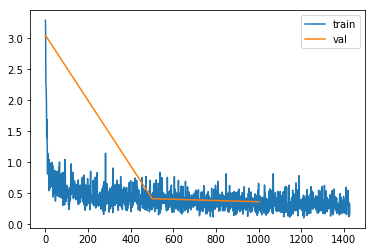

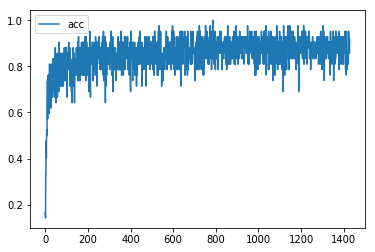

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"


# "We want to understand how to build new modules that take parameters" (i.e. how did pytorch code up nn.Conv2d?)
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True,
                 padding_mode='zeros', init_strategy=""):
        # locals() is a dictionary of items that are currently defined in this scope (/giphy mind blown)
        # update() merges 2 dictionaries
        # self.__dict__ represents the members of the class in python (/giphy wild)
        # This line of code accomplishes self.in_channels = in_channels ... self.padding_mode = padding_mode
        self.__dict__.update(locals())
        super(Conv2d, self).__init__()

        # weight is a 4d tensor of size (out, in, k, k) where k is kernel size
        # "Parameter is a pytorch object which has data as a thing, will provide grad and other handy operations on tensors that are useful for updating" (TODO: read doc?)
        self.weight = Parameter(torch.Tensor(out_channels,
                                             in_channels,
                                             *kernel_size))  # kernel_size[0], kernel_size[1]
        self.bias = Parameter(torch.Tensor(out_channels))

        self.weight.data.uniform_(-1, 1)
        self.bias.data.uniform_(0, 0)

        # initialize these
        if init_strategy == 'xav':
            torch.nn.init.xavier_uniform_(self.weight)
        elif init_strategy == 'orth':
            M = np.random.random((self.out_channels, self.in_channels * kernel_size[0] * kernel_size[1])).astype(
                np.float32)
            U, _, Vt = np.linalg.svd(M, full_matrices=False)
            if len(M) > len(M[0]):  # If M has more rows than columns, take U instead of V
                W = U.reshape((self.out_channels, self.in_channels, kernel_size[0], kernel_size[1]))
            else:
                W = Vt.reshape((self.out_channels, self.in_channels, kernel_size[0], kernel_size[1]))
            self.weight.data = torch.from_numpy(W)  # sends those weights to the weight matrix
        elif init_strategy == 'uni':
            self.weight.data.uniform_(-1, 1)
        else:
            # xav if not specified
            torch.nn.init.xavier_uniform_(self.weight)

    def forward(self, x):
        # pytorch functionals: like modules (layers), except they're just the functions that run the code
        # This runs convolutions with our weights
        return F.conv2d(x, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def extra_repr(self):
        return "boink"  # todo: remove


# CrossEntropyLoss: minimize the distance between two distributions
class CrossEntropyLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean'):
        self.__dict__.update(locals())
        super(CrossEntropyLoss, self).__init__()

    def forward(self, y_hat, y_truth):
        wrong_class_penalty = torch.log(torch.sum(torch.exp(y_hat), dim=1))
        bch_sz, classes = y_hat.shape
        # one hot encode
        b = torch.zeros(size=(bch_sz, classes))
        b[np.arange(bch_sz), y_truth] = 1
        true_class_preds = torch.sum(y_hat * b.cuda(), dim=1)
        return torch.mean(-true_class_preds + wrong_class_penalty)


class ConvNetwork(nn.Module):
    def __init__(self, dataset):
        super(ConvNetwork, self).__init__()
        x, y = dataset[0]
        c, h, w = x.size()
        output = 10

        self.net = nn.Sequential(
            Conv2d(in_channels=c, out_channels=10, kernel_size=(3, 3), padding=(1, 1), init_strategy='orth'),
            nn.ReLU(),
            Conv2d(in_channels=10, out_channels=32, kernel_size=(3, 3), padding=(1, 1), init_strategy='orth'),
            nn.ReLU(),
            Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=(1, 1), init_strategy='xav'),
            nn.ReLU(),
            Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=(1, 1), init_strategy='xav'),
            nn.ReLU(),
            Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=(1, 1), init_strategy='uni'),
            nn.ReLU(),
            Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), padding=(1, 1), init_strategy='orth'),
            nn.ReLU(),
            Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=(1, 1), init_strategy='orth'),
            nn.ReLU(),
            Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=(1, 1), init_strategy='uni'),
            nn.ReLU(),
            Conv2d(in_channels=32, out_channels=output, kernel_size=(28, 28), padding=(0,0))
        )

    def forward(self, x):
        # self.net(x) returns (n,10,1,1) sized object, and we simply want an (n,10)
        # Thus we squeeze the second dimension twice: (n,10,1,1)->(n,10,1)->(n,10)
        return self.net(x).squeeze(2).squeeze(2)

# Use the dataset class you created in lab2
class FashionMNISTProcessedDataset(Dataset):
    def __init__(self, root, train=True):
        print(root)
        self.data = datasets.FashionMNIST(root,
                                          train=train,
                                          transform=transforms.ToTensor(),
                                          download=True)
        # a 10x10 identity matrix
        self.e = torch.eye(10)

    # if you were to look up "Dataset" documentation, __getitem__ is an essential thing
    def __getitem__(self, i):
        x, y = self.data[i]
        # THIS FUNCTION RULES, it allows you to evaluate expressions IN SCOPE !!! Just like in jetbrains
        # pdb.set_trace()
        return x, y

    # right now, this will have the model train on the whole dataset
    def __len__(self):
        return len(self.data)

# SETUP
# Datasets
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist')
val_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)
# Model
model = ConvNetwork(train_dataset)
model = model.cuda()
# Loss Function (code up this class yourself)
objective = CrossEntropyLoss()
# Optimizer (TODO)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# Loaders
train_loader = DataLoader(train_dataset,
                          batch_size=42,
                          pin_memory=True)
val_loader = DataLoader(val_dataset,
                        batch_size=42,
                        pin_memory=True)

# TRAIN
losses = []
validations = []
accuracies = []

for epoch in range(1):
    loop = tqdm(total=len(train_loader), position=0, leave=False)

    for batch, (x, y_truth) in enumerate(train_loader):
        # 1. Get the actual input and output from train_loader (x, y_truth)
        x = x.cuda(async=True)
        y_truth = y_truth.cuda(async=True)
        # 2. Zero gradient the optimizer for some reason (TODO)
        optimizer.zero_grad()
        # 3. Get prediction
        y_hat = model(x)
        # 4. Compute loss
        loss = objective(y_hat, y_truth)
        # 5. Backpropagate the loss ?? (TODO)
        loss.backward()
        # 6. ? (TODO)
        optimizer.step()

        # Housekeeping
        losses.append(
            loss.item())  # Why objective returns a tensor -> Thus loss is a tensor -> Thus you must call .item() in order to access the actual value inside the tensor
        accuracy = (torch.softmax(y_hat,1).argmax(1) == y_truth).float().mean() # Don't know what this is, ur going to have to code this up yourself
        accuracies.append(accuracy.item())
        loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.3f}'.format(epoch, loss, accuracy))
        loop.update(1)

        # Validation Loop (cute and optimized)
        if batch % 500 == 0:
            # compute the loss for all x, y in val_loader, then get the mean of those losses
            val = np.mean([objective(model(x.cuda()), y.cuda()).item()
                           for x, y in val_loader
                           ])
            validations.append((len(losses), val))

    loop.close()

print('loss: ', loss)
print('acc: ', accuracy)
# PLOT
# validations is a list of tuples, this unzips it into two lists
a, b = zip(*validations)
plt.plot(losses, label='train')
plt.plot(a, b, label='val')
plt.legend()
plt.show()
# Show accuracy progression
plt.plot(accuracies, label='acc')
plt.legend()
plt.show()

In [20]:
(torch.softmax(y_hat,1).argmax(1) == y_truth).float().mean()

tensor(0.8750, device='cuda:0')

In [0]:
a = torch.from_numpy(np.random.rand(3,10,1).astype(np.float32))

In [0]:
# Both of these will be necessary for you to know how to do the softmax part, plus the torch.log idea
b = torch.exp(a)
# a.size(), b.sum(1, keepdim=True).size()
z = a / b.sum(1, keepdim=True)
z.size()
# Currently, size represents (# batch instances, # classes, # of #s in each class)

In [0]:
i = y_truth[:3]
r = torch.arange(b.size(0))
c = i
# indexing into b and getting b[0,4],b[1,2],b[2,9]
b[r,c]

In [0]:
r,c

In [0]:
# ACCURACY
# Output from model will be an enormous tensor with numbers for each class that you're predicting
# You might want to know what the argmax is
# This is the classes that your network thinks is most likely for each item
torch.softmax(y_hat,1).argmax(1)
# To find accuracy I want to compare these numbers to y_truth (following 2 lines are equivalent statements. First one is more explicit)
(torch.softmax(y_hat,1).argmax(1) == y_truth).float().mean()
(y_hat.argmax(1) == y_truth).float().mean()
# "That will help compute accuracy for each batch, and if you want to avg that over whole val dataset, you can print that"

# gives a generator for all params in model
model.parameters()
for p in model.parameters():
    print(p.size())
    for s in p.size():
        print(s)
# for some reason you will want to add the products of these sizes. Have some fun, try to do it w/ a list comprehension
# consider using: np.prod(p.size()) for this

In [66]:
wrong_class_penalty = torch.log(torch.sum(torch.exp(y_hat), dim=1))
bch_sz, classes = y_hat.size()
# one hot encode
b = torch.zeros(size=(bch_sz,classes))
b[np.arange(bch_sz), y_truth] = 1
true_class_preds = torch.sum(y_hat * b.cuda(), dim=1)
CEL = torch.mean(wrong_class_penalty - true_class_preds)


tensor(4.4355, device='cuda:0', grad_fn=<MeanBackward0>)

___

### Part 1
Re-implement a Conv2D module with parameters and a CrossEntropy loss function.

**TODO:**



**DONE:**
* CrossEntropyLoss 
* Conv2D
___

### Part 2
Implement a few initialization strategies which can include Xe initialization
(sometimes called Xavier), Orthogonal initialization, and uniform random.
You can specify which strategy you want to use with a parameter. 


use pytorch's built in xe
use uniform from video
build your own orthogonal


Helpful links include:
*  [Orthogonal Initialization](https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers) (or the original paper: http://arxiv.org/abs/1312.6120)
*  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

**TODO:**


**DONE:**
* Parameterize custom Conv2D for different initilization strategies
* Xe
* Orthogonal
* Uniform


In [0]:
class CrossEntropyLoss(nn.Module):
  pass

class Conv2d(nn.Module):
  pass


In [0]:
class ConvNetwork(nn.Module):
  pass


In [0]:
# Initialize Datasets

# Initialize DataLoaders

# Initialize Model

# Initialize Objective and Optimizer and other parameters


In [0]:

# Run your training and validation loop and collect stats



___

### Part 3
Print the number of parameters in your network and plot accuracy of your training and validation 
set over time. You should experiment with some deep networks and see if you can get a network 
with close to 1,000,000 parameters.

**TODO:**
* Experiment with Deep Networks
* Plot accuracy of training and validation set over time
* Print out number of parameters in the model 

**DONE:**


In [0]:

# Go back up and try a few different networks and initialization strategies
# Plot loss if you want
# Plot accuracy



In [45]:
# Compute and print the number of parameters in the model
model.parameters()
sum = 0
for p in model.parameters():
    sz = list(p.size())
#     print(sz)
    prod = np.prod(sz)
#     print(prod)
    sum += prod

print(sum)

1028718


___

### Part 4
Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.


*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **(out_channels=22, kernel_size=(3, 3), padding=(1, 1))**
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : **(out_channels=65, kernel_size=(3, 3), padding=(2, 2))**
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : **(out_channels=7, kernel_size=(3, 3), padding=(6,6))**

*Using a Kernel size of 5×5:*)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out_channels=100, kernel_size=(5, 5), padding=(2, 2))**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out_channels=23, kernel_size=(5, 5), padding=(3, 3))**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out_channels=5, kernel_size=(5, 5), padding=(9, 9))**

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **(out_channels=10, kernel_size=(5, 3), padding=(1, 0))**
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out_channels=100, kernel_size=(5, 3), padding=(2, 1))**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out_channels=23, kernel_size=(5, 3), padding=(3, 2))**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out_channels=5, kernel_size=(5, 3), padding=(9, 8))**

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : **kernel_size=(2,4)**
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **kernel_size=(1,1)**

**TODO:**



**DONE:**

* Answer all the questions above 


In [0]:
# Write some test code for checking the answers for these problems (example shown in the video)
model.parameters()
sum = 0
for p in model.parameters():
    sz = list(p.size())
    print(sz)
    prod = np.prod(sz)
    print(prod)
    sum += prod

print(sum)